# Create a Lightcurve Simulator in Gammapy-0.20

## 0 - Setup: import packages of the environment gammapy-0.20

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import numpy as np
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table, QTable
from astropy.io import fits

import logging
log = logging.getLogger(__name__)

In [2]:
from gammapy.data import Observation
from gammapy.data import observatory_locations
from gammapy.datasets import SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.irf import (
    load_cta_irfs,
    EffectiveAreaTable2D,
    Background2D, Background3D,
    EnergyDispersion2D, EDispKernel, EDispKernelMap,
    FoVAlignment
)
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    ExpDecayTemporalModel,
    SkyModel,
    ExpCutoffPowerLaw3FGLSpectralModel,
    GeneralizedGaussianTemporalModel,
    LightCurveTemplateTemporalModel
)
from gammapy.utils.random import get_random_state

#### Files to load

In [3]:
# Define Data Directory
input_directory = "/home/gabriele/Documents/fermiGBM/"

# Define PHA file
file_pha = input_directory + "Output/grb_120323_A/grb_120323_A_n0.pha"

# Define BAK file
file_bak = input_directory + "Output/grb_120323_A/grb_120323_A_n0.bak"

# Define TTE fits file
file_tte = input_directory + "FermiData/bn120323507/glg_tte_n0_bn120323507_v00.fit"

# Define RSP file
file_rsp = input_directory + "FermiData/bn120323507/glg_cspec_n0_bn120323507_v01.rsp"

In [ ]:
# hdulist_tte = fits.open(file_tte)
# hdulist_tte.info()
# hdulist_tte['PRIMARY'].header

## 1 - Load the Detector Response Matrix

This file is used to define a Reference Time, a Pointing Direction, the True Energy Axis, the Reconstructed Energy Axis, the Detector Response Matrix, the Effective Area.

In [4]:
hdulist_rsp = fits.open(file_rsp)

# Print the Information and Primary Header
print(hdulist_rsp.info())
# hdulist_rsp['PRIMARY'].header

Filename: /home/gabriele/Documents/fermiGBM/FermiData/bn120323507/glg_cspec_n0_bn120323507_v01.rsp
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  EBOUNDS       1 BinTableHDU     57   128R x 3C   [1I, 1E, 1E]   
  2  SPECRESP MATRIX    1 BinTableHDU     67   140R x 6C   [1E, 1E, 1I, PI(128), PI(128), PE(128)]   
None


#### 1.1 - Define the Reference Time of the simulated observations

In [5]:
# Define the Trigger Time as the Reference Time of the simulated observations
TIMESYS= hdulist_rsp['PRIMARY'].header['TIMESYS'].lower()

ref_t0 = hdulist_rsp['PRIMARY'].header['MJDREFI']
ref_t0+= hdulist_rsp['PRIMARY'].header['MJDREFF']
ref_t0+= hdulist_rsp['PRIMARY'].header['TRIGTIME']/86400.0

ref_t0 = Time(ref_t0,
              format = 'mjd',
              scale = TIMESYS
             )

# Define preferred time format
TimeMapAxis.time_format = "iso" 
ref_t0.format = TimeMapAxis.time_format

# Print
ref_t0

<Time object: scale='tt' format='iso' value=2012-03-23 12:11:25.907>

#### 1.2 - Define the Pointing Direction of the simulated observations

We must define a *pointing* direction.
In IACTs this is very close to the target direction, in satellites it is very far in general for GRBs.

**What do I do?**

In [6]:
# Define the Pointing Direction of the simulated instrument as the Object direction
RA_OBJ  = hdulist_rsp['PRIMARY'].header['RA_OBJ' ]
DEC_OBJ = hdulist_rsp['PRIMARY'].header['DEC_OBJ']
FRAME   = hdulist_rsp['PRIMARY'].header['RADECSYS'].lower()

pointing = SkyCoord(RA_OBJ,
                    DEC_OBJ,
                    unit = "deg",
                    frame = FRAME
                   )

# Print
pointing

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (340.4, 29.7)>

#### 1.3 - Define the Reconstructed Energy Axis
This is done from the EBOUNDS hdu of the response file.

In [7]:
# Choose how to interpolate the energies
INTERP = 'log' # 'lin' or 'log'

In [8]:
# Define the Reconstructed Energy Axis
ebounds = hdulist_rsp['EBOUNDS'].header['EXTNAME']

reco_table = Table.read( hdulist_rsp[ebounds] )

reco_energy_min = reco_table["E_MIN"].quantity
reco_energy_max = reco_table["E_MAX"].quantity

# Define Edges
reco_energy_edges = np.append(reco_energy_min.value, reco_energy_max.value[-1]) * reco_energy_min.unit

# Define Axis
axis_energy_reco = MapAxis.from_edges(reco_energy_edges,
                                      name = "energy",
                                      interp = INTERP
                                     )

# Print
print(axis_energy_reco)
# reco_table

MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 128       
	node type  : edges     
	edges min  : 4.6e+00 keV
	edges max  : 2.0e+03 keV
	interp     : log       



#### 1.4 - Define the Source Geometry: a region in the sky where the source is placed.
This represents a single pixel on the sky.

In [9]:
geometry_radius = 1.0 * u.deg
source_geometry_str = FRAME+';circle('+str(RA_OBJ)+', '+str(DEC_OBJ)+', '+str(geometry_radius.value)+')'

# Geometry object: a sky region covered by a pixel, with arbitrary shape and size
geom = RegionGeom.create(source_geometry_str, axes = [axis_energy_reco])
geom

RegionGeom

	region     : CircleSkyRegion
	axes       : ['lon', 'lat', 'energy']
	shape      : (1, 1, 128)
	ndim       : 3
	frame      : fk5
	center     : 340.4 deg, 29.7 deg

#### 1.4 - Define the True Energy Axis
This is done from the SPECRESP MATRIX hdu of the response file.
This name might change.

In [10]:
specresp_matrix = hdulist_rsp['SPECRESP MATRIX'].header['EXTNAME']

# Define the True Energy Axis
true_table = Table.read( hdulist_rsp[specresp_matrix] )

true_energy_min = true_table["ENERG_LO"].quantity
true_energy_max = true_table["ENERG_HI"].quantity

# To avoid that min edge is 0
true_energy_min[0] += 1e-2 * (true_energy_max[0] - true_energy_min[0])

# Define Edges
true_energy_edges = np.append(true_energy_min.value, true_energy_max.value[-1]) * true_energy_min.unit

# Define Axis
axis_energy_true = MapAxis.from_edges(true_energy_edges,
                                      name = "energy_true",
                                      interp = INTERP
                                     )
# Print
print(axis_energy_true)
# true_table

MapAxis

	name       : energy_true
	unit       : 'keV'     
	nbins      : 140       
	node type  : edges     
	edges min  : 5.0e+00 keV
	edges max  : 5.0e+04 keV
	interp     : log       



#### 1.5 - Load the Spectral Response Matrix: Effective Area vs True and Reconstructed Energy

In [11]:
Matrix_hdu = hdulist_rsp[specresp_matrix]
Matrix_header = Matrix_hdu.header
Matrix_data = Matrix_hdu.data

Matrix_array = np.zeros([len(Matrix_data), Matrix_header["DETCHANS"]], dtype = np.float64)

for i, l in enumerate(Matrix_data):
    if l.field("N_GRP"):
        m_start = 0
        for k in range(l.field("N_GRP")):
            
            if np.isscalar(l.field("N_CHAN")):
                f_chan = l.field("F_CHAN") - 1
                n_chan = l.field("N_CHAN")
            else:
                f_chan = l.field("F_CHAN")[k] - 1
                n_chan = l.field("N_CHAN")[k]

            Matrix_array[i, f_chan : f_chan+n_chan] = l.field("MATRIX")[m_start : m_start+n_chan]
            m_start += n_chan

# Values are set, now define the unit of measure.
Matrix_unit = true_table['MATRIX'].unit

# Compute the total Effective Area
Total_aeff = np.sum(Matrix_array) * Matrix_unit
print('Total effective area: {}.'.format(Total_aeff))

# Divide Matrix array by the total effective area to get an adimensional result
# Matrix_adim = Matrix_array / Total_aeff.value

Total effective area: 7391.495777348258 cm2.


#### 1.6 - Build the Energy Dispersion Kernel

In [ ]:
# data = Matrix_adim
# new_data = np.empty(Matrix_adim.shape)
# results = np.empty(data[0].shape)

# for i in range(len(results)):
#     results[i] = np.sum(data[i])
#     new_data[i] = data[i]/results[i]

# #results
# new_data
# for i in range(len(results)):
#     results[i] = np.sum(new_data[i])

# Matrix_adim[-1]


In [ ]:
# edisp_kernel = EDispKernel(axes = [axis_energy_true, axis_energy_reco], data = new_data)
# edisp_kernel.plot_matrix(add_cbar=True)

# data = edisp_kernel.data
# results = np.empty(data[0].shape)

# for i in range(len(results)):
#     results[i] = np.sum(data[i])

# # results

In [ ]:
# # Print
# f, a = plt.subplots( figsize = (10,5) )

# a = edisp_kernel.plot_matrix(add_cbar = True,
#                                 norm = PowerNorm(gamma=0.3),
#                                 cmap = 'plasma'
#                                )
# a.set_facecolor('black')
# a.set_xscale('log')
# a.set_yscale('log')
# a.set_title('Energy Dispersion kernel: PowerNorm(0.3)')

# plt.show()

# # Print
# f, a = plt.subplots(figsize = (10,5) )

# a = edisp_kernel.plot_matrix(add_cbar = True,
#                                 norm = LogNorm(vmin=4.0e-11),
#                                 cmap = 'plasma'
#                                )
# a.set_facecolor('black')
# a.set_xscale('log')
# a.set_yscale('log')
# a.set_title('Energy Dispersion kernel: LogNorm()')

# plt.show()

In [ ]:
# edisp_kermap = EDispKernelMap.from_edisp_kernel(edisp_kernel, geom = geom)
# edisp_kermap.peek()

#### 1.6 - Define the Effective Area

Plot the Effective Area vs True Energy

In [12]:
# Create Offset axis
axis_offset = MapAxis.from_bounds(0.0,                  # Minimum Offset
                                  10.0,                 # Maximum Offset
                                  unit = "degree",
                                  nbin = 10,
                                  name = "offset"
                                 )

# Print
print(axis_offset)
# axis_offset.as_plot_labels

MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 10        
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 1.0e+01 deg
	interp     : lin       



EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (140, 10)
  ndim  : 2
  unit  : cm2
  dtype : float64



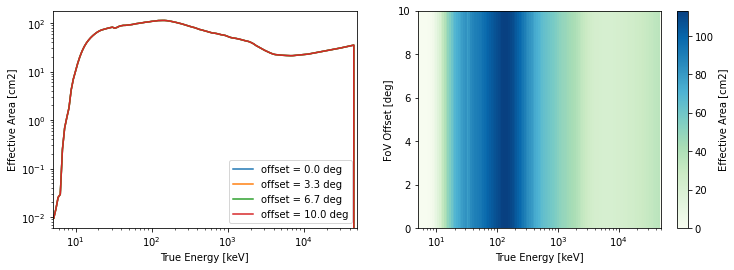

In [13]:
# Prepare Effective Area Matrix (as a function of energy and offset) as ndarray
aeff_matrix = np.ndarray( (axis_energy_true.nbin, axis_offset.nbin) )

# Compute effective area
aeff_array = np.sum(Matrix_array, axis=1)

for i in range(axis_offset.nbin):
    aeff_matrix.transpose()[i] = aeff_array

# Instantiate Effective Area object
aeff = EffectiveAreaTable2D(axes = [axis_energy_true, axis_offset],
                            data = aeff_matrix,
                            unit = Matrix_unit
                            # meta = metadata dictionary from header
                           )

# Print
print(aeff)

fig, axs = plt.subplots(1,2, figsize=(12,4))

aeff.plot_energy_dependence(ax = axs[0], offset = None)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

aeff.plot(ax = axs[1], add_cbar = True)
axs[1].set_xscale('log')

plt.show()

## 2 - Doubts: PHA file and Energy Dispersion Matrix

Why?
**THE RA AND DEC ARE COMPLETELY DIFFERENT. WHY?**

In [14]:
# Load a file that contains information about the position
hdulist_pha = fits.open(file_pha)

# Print the Information and Primary Header
print(hdulist_pha.info())
# hdulist_pha['PRIMARY'].header

Filename: /home/gabriele/Documents/fermiGBM/Output/grb_120323_A/grb_120323_A_n0.pha
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   ()      
  1  EBOUNDS       1 BinTableHDU     49   128R x 3C   [I, E, E]   
  2  SPECTRUM      1 BinTableHDU     60   128R x 3C   [I, J, I]   
  3  GTI           1 BinTableHDU     40   1R x 2C   [D, D]   
None


EnergyDispersion2D
------------------

  axes  : ['energy_true', 'migra', 'offset']
  shape : (140, 100, 10)
  ndim  : 3
  unit  : 
  dtype : float64



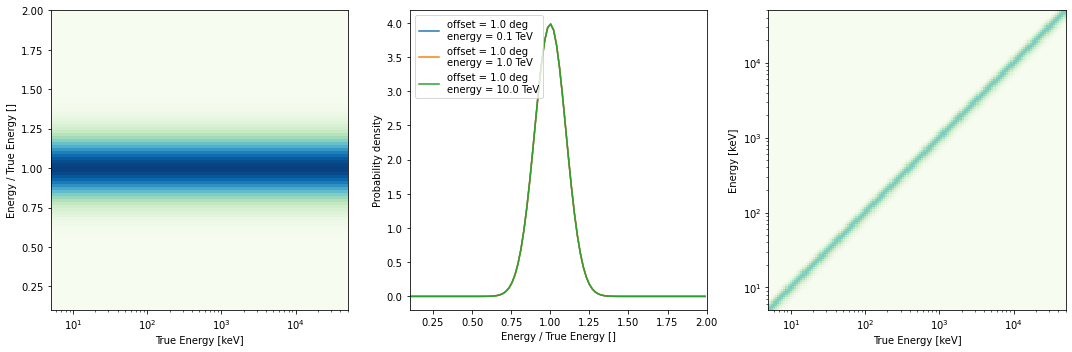

In [15]:
# Create Axis of Energy Migration
axis_energy_migr = MapAxis.from_bounds(0.1, 2.0,
                                       nbin = 100,
                                       name = "migra")

# Instantiate Energy Dispersion Matrix object # I should add meta=metadata dictionary from header
edisp = EnergyDispersion2D.from_gauss(energy_axis_true = axis_energy_true,
                                      migra_axis       = axis_energy_migr,
                                      offset_axis      = axis_offset,
                                      bias             = 0,
                                      sigma            = 0.1,
                                      # interp           = 'lin' # Gaussian is in log
                                     )

# Print
print(edisp)
edisp.peek()

<AxesSubplot:xlabel='True Energy [keV]', ylabel='Energy [keV]'>

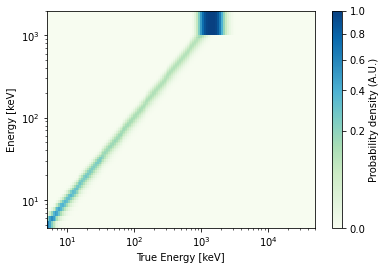

In [16]:
edisp_kernel = edisp.to_edisp_kernel(offset=0.0*u.deg)
edisp_kernel = EDispKernel.from_gauss(energy_axis_true = axis_energy_true,
                                      energy_axis      = axis_energy_reco,
                                      bias             = 0,
                                      sigma            = 0.1
                                     )
edisp_kernel.plot_matrix(add_cbar=True)

In [17]:
edisp_kermap = EDispKernelMap.from_edisp_kernel(edisp.to_edisp_kernel(offset=0.0*u.deg), geom=geom)
edisp_kermap.edisp_map

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'energy', 'energy_true']
	shape : (1, 1, 140, 140)
	ndim  : 4
	unit  : 
	dtype : float32

## 3 - Load the Background

This is used to define the Backrgound Spectral Model.
We also need the Lon and Lat axes.

In [ ]:
# Create Instrument FoV_lon axis
axis_fovlon = MapAxis.from_bounds(-5.0, 5.0,
                                  unit = "degree",
                                  nbin = 10,
                                  name = "fov_lon"
                                 )

# Print
print(axis_fovlon)
#axis_fovlon.as_plot_labels

In [ ]:
# Create Instrument FoV_lat axis
axis_fovlat = MapAxis.from_bounds(-5.0, 5.0,
                                  unit = "degree",
                                  nbin = 10,
                                  name = "fov_lat"
                                 )

# Print
print(axis_fovlat)
#axis_fovlat.as_plot_labels

Load the Background File

In [ ]:
hdulist_bak = fits.open(file_bak)

# Print the Information and Primary Header
print(hdulist_bak.info())
# hdulist_bak['PRIMARY'].header

In [ ]:
bkg_e_min = hdulist_bak['EBOUNDS' ].data['E_MIN'] # keV
bkg_e_max = hdulist_bak['EBOUNDS' ].data['E_MAX'] # keV
bkg_rates = hdulist_bak['SPECTRUM'].data['RATE' ] # cts/s/ch

bkg_quantity = bkg_rates / (bkg_e_max - bkg_e_min) * (u.keV*u.s)**(-1) # cts/s/keV

# Divide by the solid angle of the Source Region

bkg_quantity = bkg_quantity / geom.solid_angle() # cts/s/keV/sr

In [ ]:
# Prepare Background Matrix (as a function of energy, lon and lat) as ndarray
data_bak = np.ndarray( (axis_energy_reco.nbin, axis_fovlon.nbin, axis_fovlat.nbin) )

for i in range(axis_fovlat.nbin):
    for j in range(axis_fovlon.nbin):
        data_bak.transpose()[i][j] = bkg_quantity.value

# Instantiate Background object # I should add meta=metadata dictionary from header    
bkg = Background3D(axes = [axis_energy_reco, axis_fovlon, axis_fovlat],
                   data = data_bak,
                   unit = bkg_quantity.unit,
                   #is_pointlike = False,
                   #fov_alignment = FoVAlignment.RADEC,
                   #meta = None,
                   #interp_kwargs = None
                   )

# Print
print(bkg)
bkg.peek()

#### Build IRFs object (dictionary)

In [ ]:
IRFs = {'aeff' : aeff,
        'bkg'  : bkg,
        'edisp': edisp_kermap
       }

## 4 - Define Temporal and Spectral Model for the simulated source

In [ ]:
# Load the table from FermiGBM of the best fit

GBM_original_name = '/home/gabriele/Documents/fermiGBM/Output/grb_120323_A/'
GBM_original_name+= 'table_fit_LC_n0_10_900_keV.fits'

GBM_original = QTable.read(GBM_original_name, format='fits')

In [ ]:
# Spectral model

GBM_Ampli = (1.12) * (u.cm**(-2) * u.s**(-1) * u.keV**(-1))
GBM_Index =-1.52 * u.Unit("")
GBM_Epeak = 413.79 * u.keV
GBM_Erefe = 100.00 * u.keV

spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude = GBM_Ampli,
    index     = - GBM_Index,
    lambda_   = (2.0 + GBM_Index ) / GBM_Epeak,
    reference = GBM_Erefe
)


# Temporal model

Temporal_Model_Table_Metadata = {'MJDREFI' : int(np.modf(ref_t0.mjd)[1]),
                                 'MJDREFF' : np.modf(ref_t0.mjd)[0],
                                 'TIMEUNIT': GBM_original['time'].unit.to_string(),
                                 'TIMESYS' : ref_t0.scale
                                }

Temporal_Model_Table = Table(meta = Temporal_Model_Table_Metadata)
Temporal_Model_Table['TIME'] = GBM_original['time']
Temporal_Model_Table['NORM'] = GBM_original['norm']

temporal_model = LightCurveTemplateTemporalModel(Temporal_Model_Table)


# Complete Source Model = Temporal & Spectral
model_simu = SkyModel(
    spectral_model = spectral_model,
    temporal_model = temporal_model,
    name           = "model-simu"
)

In [ ]:
# Print
energy_bounds = [axis_energy_true.edges[0], axis_energy_true.edges[-1]]
spectral_model.plot(energy_bounds,sed_type='flux')
plt.grid(which="both")
plt.show()

time_range = [ref_t0-0.3*u.s, ref_t0 + 0.8*u.s]
temporal_model.plot(time_range)
plt.grid(which="both")
plt.show()

model_simu.parameters.to_table()

### 4 - Define observation number, start and duration

In [ ]:
time_unit  = u.s
t_start_obs=-0.305 * time_unit # Start time of the observations wrt to trigger time ref_t0
t_stop_obs = 0.795 * time_unit # Stop time of the observations wrt to trigger time ref_t0
live_t_obs = 0.010 * time_unit # Time duration of each observation
dead_times = 0.001 * time_unit # Rest time between observations

# Estimate Number of observations
n_obs = (t_stop_obs-t_start_obs)/live_t_obs
n_obs = int(np.floor(n_obs.value))

# Define starting time of each observation linearly spaced during the night
starting_times = np.linspace(t_start_obs.value,
                             t_stop_obs.value,
                             num = n_obs
                            )
starting_times = starting_times.tolist() * time_unit

# Define the duration of each observation as the difference between two following starting times
# minus the rest time between them.
livetimes = starting_times[1:] - starting_times[:-1] - dead_times

# Remove last edge to have the same array dimesion for starting times and livetimes.
starting_times = starting_times[:-1]

# Turn them from astropy.units.quantity.Quantity to astropy.time.core.Time with t_ref
starting_times = Time(ref_t0 + starting_times)

# Adjust n_obs
n_obs = starting_times.size

In [ ]:
# Get the GBM data in the Gammapy time interval
i_start= np.argmin(np.abs(GBM_original['time'].value - t_start_obs.value))
i_stop = np.argmin(np.abs(GBM_original['time'].value - t_stop_obs.value ))
    
GBM_original = GBM_original[i_start:i_stop]

In [ ]:
my_EDispKernelMap = edisp_kermap

In [ ]:
IRFs = {'aeff': aeff, 'bkg': bkg, 'edisp': my_EDispKernelMap}
empty = SpectrumDataset.create(geom = geom,
                               energy_axis_true = axis_energy_true,
                               name = "empty",
                               edisp = my_EDispKernelMap
                              )
maker = SpectrumDatasetMaker(selection = ["exposure", "background", "edisp"])
datasets = Datasets()
    
for idx in range(n_obs):
    
    obs = Observation.create(pointing = pointing,
                             livetime = livetimes[idx],
                             tstart = starting_times[idx],
                             irfs = IRFs,
                             reference_time = ref_t0,
                             obs_id = idx
                            )
    empty_i = empty.copy(name = f"Dataset-{idx}")
    dataset = maker.run(empty_i, obs)
    dataset.models = model_simu
    dataset.fake()
    datasets.append(dataset)

In [ ]:
datasets.info_table()

In [ ]:
show_columns = ['name',
                'counts',
                'npred',
                'background',
                'npred_signal',
                'counts_rate',
                'background_rate'
               ]

List_of_Datasets[0].info_table()[show_columns][48:53]#, List_of_Datasets[1].info_table()[show_columns][48:53]

In [ ]:
def plot_one_curve(curve_index):
    
    # Define Plot Quantities
    time_centroids = starting_times + livetimes / 2.0 - ref_t0
    time_centroids = time_centroids.sec
    
    # Choose one Light curve
    datasets = List_of_Datasets[curve_index]
    
    count_rates     = datasets.info_table()['counts_rate'].value
    count_rates_err = count_rates / np.sqrt(datasets.info_table()['counts'].value) # NO!
    
    backg_rates     = datasets.info_table()['background_rate'].value
    backg_rates_err = backg_rates / np.sqrt(datasets.info_table()['background'].value)  # NO!
    
    # Define pyplot Figure and Axes
    fig, axs = plt.subplots(1, figsize = (15.0, 7.0) )
    
    # Plot Light Curve Model of best fit to GBM Data (No Background)
    # axs.plot(GBM_original['time'].value, GBM_original['best_model'].value,
    #          label = 'GBM Best Model (No bkg)', color = 'black'
    #         )
    
    # Plot GBM Data + Error
    axs.step(GBM_original['time'].value, GBM_original['cnt_rt'].value,
             label = 'GBM Count rates', color = 'C1', where = 'mid'
            )
    axs.bar(x = GBM_original['time'].value,
            height = 2.0 * GBM_original['cnt_rt_err'].value,
            bottom = GBM_original['cnt_rt'].value - GBM_original['cnt_rt_err'].value,
            width = GBM_original['time_width'].value,
            align = 'center', color = 'C1', alpha = 0.5, #label = 'GBM count rates error'
           )

    # Plot GBM Background + Error
    axs.step(GBM_original['time'].value, GBM_original['bkg_rt'].value,
             label = 'GBM bkgd rates', color = 'C2', where = 'mid'
            )
    axs.bar(x = GBM_original['time'].value,
            height = 2.0 * GBM_original['bkg_rt_err'].value,
            bottom = GBM_original['bkg_rt'].value - GBM_original['bkg_rt_err'].value,
            width = GBM_original['time_width'].value,
            align = 'center', color = 'C2', alpha = 0.5, #label = 'GBM bkgd rates error'
           )
    
    # Plot Simulated Light Curve + Error
    axs.step(time_centroids, count_rates,
             label = 'Simulated Count rates', color = 'C0', where = 'mid'
            )
    axs.bar(x = time_centroids,
            height = 2.0 * count_rates_err,
            bottom = count_rates - count_rates_err,
            width = livetimes.value,
            align = 'center', color = 'C0', alpha = 0.5, #label = 'Simulated Count rates error'
           )
    
    # Plot Simulated Background + Error
    axs.step(time_centroids, backg_rates,
             label = 'Simulated Bkgd rates', color = 'C3', where = 'mid'
            )
    axs.bar(x = time_centroids,
            height = 2.0 * backg_rates_err,
            bottom = backg_rates - backg_rates_err,
            width = livetimes.value,
            align = 'center', color = 'C3', alpha = 0.5, #label = 'Simulated Bkgd rates error'
           )
    
    # Set Labels
    axs.set_xlabel('Time since trigger (s)')
    axs.set_ylabel('Count rates (cts/s)')
    plot_title = 'Simulated lightcurve {}/{}.'.format(curve_index+1, Number_of_LightCurves)
    plot_title+= ' Simulation of GRB 120323 A, seen by FermiGBM detector n0.'
    axs.set_title(plot_title)
    axs.grid()
    axs.legend()
    
    plt.show()
    

In [ ]:
plot_one_curve(0)

In [ ]:
def plot_avg_LC():

    # Define Plot Quantities
    time_centroids = starting_times + livetimes / 2.0 - ref_t0
    time_centroids = time_centroids.sec
    
    # Shape
    n_rows = Number_of_LightCurves
    n_columns = np.size(List_of_Datasets[0].info_table()['counts_rate'].value)
    
    all_count_rates_columns = np.empty( (n_rows, n_columns) )
    all_backg_rates_columns = np.empty( (n_rows, n_columns) )
    
    for i in range(n_rows):
        all_count_rates_columns[i] = List_of_Datasets[i].info_table()['counts_rate'    ].value
        all_backg_rates_columns[i] = List_of_Datasets[i].info_table()['background_rate'].value
        
    count_rates = np.mean(all_count_rates_columns, axis=0)
    backg_rates = np.mean(all_backg_rates_columns, axis=0)
    
    #count_rates_err = count_rates / np.sqrt(datasets.info_table()['counts'].value) # NO!
    #backg_rates_err = backg_rates / np.sqrt(datasets.info_table()['background'].value)  # NO!
    
    # Define pyplot Figure and Axes
    fig, axs = plt.subplots(1, figsize = (15.0, 7.0) )
    
    # Plot Light Curve Model of best fit to GBM Data (No Background)
    # axs.plot(GBM_original['time'].value, GBM_original['best_model'].value,
    #          label = 'GBM Best Model (No bkg)', color = 'black'
    #         )
    
    # Plot GBM Data + Error
    axs.step(GBM_original['time'].value, GBM_original['cnt_rt'].value,
             label = 'GBM Count rates', color = 'C1', where = 'mid'
            )
    axs.bar(x = GBM_original['time'].value,
            height = 2.0 * GBM_original['cnt_rt_err'].value,
            bottom = GBM_original['cnt_rt'].value - GBM_original['cnt_rt_err'].value,
            width = GBM_original['time_width'].value,
            align = 'center', color = 'C1', alpha = 0.5, #label = 'GBM count rates error'
           )

    # Plot GBM Background + Error
    axs.step(GBM_original['time'].value, GBM_original['bkg_rt'].value,
             label = 'GBM bkgd rates', color = 'C2', where = 'mid'
            )
    axs.bar(x = GBM_original['time'].value,
            height = 2.0 * GBM_original['bkg_rt_err'].value,
            bottom = GBM_original['bkg_rt'].value - GBM_original['bkg_rt_err'].value,
            width = GBM_original['time_width'].value,
            align = 'center', color = 'C2', alpha = 0.5, #label = 'GBM bkgd rates error'
           )
    
    # Plot Simulated Light Curve + Error
    axs.step(time_centroids, count_rates,
             label = 'Simulated Count rates', color = 'C0', where = 'mid'
            )
#     axs.bar(x = time_centroids,
#             height = 2.0 * count_rates_err,
#             bottom = count_rates - count_rates_err,
#             width = livetimes.value,
#             align = 'center', color = 'C0', alpha = 0.5, #label = 'Simulated Count rates error'
#            )
    
    # Plot Simulated Background + Error
    axs.step(time_centroids, backg_rates,
             label = 'Simulated Bkgd rates', color = 'C3', where = 'mid'
            )
#     axs.bar(x = time_centroids,
#             height = 2.0 * backg_rates_err,
#             bottom = backg_rates - backg_rates_err,
#             width = livetimes.value,
#             align = 'center', color = 'C3', alpha = 0.5, #label = 'Simulated Bkgd rates error'
#            )
    
    # Set Labels
    axs.set_xlabel('Time since trigger (s)')
    axs.set_ylabel('Count rates (cts/s)')
    plot_title = 'Averaged simulated lightcurve of GRB 120323 A, seen by FermiGBM detector n0.'
    axs.set_title(plot_title)
    axs.grid()
    axs.legend()
    
    plt.show()
    return None

In [ ]:
plot_avg_LC()

# Flux Points

In [ ]:
# Drop the Temporal Model, attach only the Spectral Model to all SpectrumDataset objects
datasets.models = SkyModel(spectral_model = spectral_model, name = "model-fit")
datasets.models.to_parameters_table()

In [ ]:
# Estimate a Flux Points light curve, each point is the flux of an observation
# The estimator fits the norm of the source model component to datasets in each time interval GTI.
#%%time
lc_maker_1d = LightCurveEstimator(energy_edges = [axis_energy_true.edges[0], axis_energy_true.edges[-1]],#OR RECO?
                                  source = "model-fit",
                                  selection_optional = ["ul"]
                                 )
# "all": all the optional steps are executed
# "errn-errp": estimate asymmetric errors.
# "ul": estimate upper limits.
# "scan": estimate fit statistic profiles.

lc_1d = lc_maker_1d.run(datasets)

In [ ]:
ax = lc_1d.plot(sed_type = "flux",  # "dnde", “flux”, “eflux”, “e2dnde”
                energy_power = 1.0, # Power of energy to multiply flux axis with
                marker = "o",
                label = "Simulated_LC")

pl_start = ref_t0 - 0.3 * u.s
pl_end   = ref_t0 + 0.8 * u.s
#ax.set_xlim(pl_start.plot_date, pl_end.plot_date)


In [ ]:
# Stack the Datasets into one Spectrum Dataset
Stacked_spectrum_dataset = datasets.stack_reduce(name = 'Stacked_sim_ds')

In [ ]:
fig, ax = plt.subplots(1, figsize = (7,5))
Stacked_spectrum_dataset.plot_counts(ax=ax)
ax.set_xscale('log')
ax.set_title('Spectrum time-integrated (stacked)')
plt.grid()
plt.show()

# Extra

In [ ]:
# from gammapy.maps import Map
# import logging
# import numpy as np
# from astropy.coordinates import Angle, SkyOffsetFrame
# from astropy.table import Table
# from gammapy.irf import EDispMap, FoVAlignment, PSFMap
# from gammapy.maps import Map, RegionNDMap
# from gammapy.modeling.models import PowerLawSpectralModel
# from gammapy.stats import WStatCountsStatistic
# from gammapy.utils.coordinates import sky_to_fov
# from gammapy.utils.regions import compound_region_to_regions

# def make_map_background_irf(pointing, ontime, bkg, geom, oversampling=None, use_region_center=True):

#     coords = {"energy": geom.axes["energy"].edges.reshape((-1, 1, 1))}

#     image_geom = geom.to_image()

#     d_omega = image_geom.solid_angle()

#     map_coord = image_geom.get_coord()

#     sky_coord = map_coord.skycoord

    
#     # Create OffsetFrame
#     frame = SkyOffsetFrame(origin = pointing.radec)
#     pseudo_fov_coord = sky_coord.transform_to(frame)
#     fov_lon = pseudo_fov_coord.lon
#     fov_lat = pseudo_fov_coord.lat

#     coords["fov_lon"] = fov_lon
#     coords["fov_lat"] = fov_lat

#     bkg_de = bkg.integrate_log_log(**coords, axis_name="energy")
    
#     #print(bkg_de)
#     #print(bkg_de * d_omega * ontime)
#     data = (bkg_de * d_omega * ontime).to_value("")
#     #print(data)

#     bkg_map = Map.from_geom(geom, data=data)

#     return bkg_map

# a = make_map_background_irf(pointing = obs.fixed_pointing_info,
#                             ontime = obs.observation_time_duration,
#                             bkg = obs.bkg,
#                             geom = geom,
#                             oversampling = maker.background_oversampling,
#                             use_region_center = getattr(maker, "use_region_center", True)
#                            )
# #a.data

In [ ]:
# mybkg = obs.bkg
# coords = {"energy": geom.axes["energy"].edges.reshape((-1, 1, 1))}
# coords["fov_lon"] = 0.0*u.deg
# coords["fov_lat"] = 0.0*u.deg


# mybkg = mybkg.integrate_log_log(**coords, axis_name = 'energy')
# mybkg = mybkg *geom.solid_angle() * obs.observation_time_duration
# mybkg = mybkg.to_value("")
# np.sum(mybkg.T[0][0])